<a href="https://colab.research.google.com/github/pipoomm/topologyzoo/blob/main/mumu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import networkx as nx
from networkx.algorithms.shortest_paths.astar import astar_path_length

import numpy as np
import pandas as pd
from math import radians, cos, sin, asin, sqrt

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import copy
import requests
from io import StringIO

In [4]:
def read_graphml_from_url(url):
    # Download the GraphML file
    response = requests.get(url)
    if response.status_code == 200:
        # Parse the GraphML content using NetworkX
        graphml_data = response.text
        graphml_file = StringIO(graphml_data)
        graph = nx.read_graphml(graphml_file)
        return graph
    else:
        raise Exception(f"Error downloading GraphML file. Status code: {response.status_code}")

In [6]:
# Load GraphML file
G = read_graphml_from_url("https://raw.githubusercontent.com/pipoomm/topologyzoo/main/AttMpls.graphml")

In [7]:
# Set the initial role of all nodes to "none"
roles = {}
for n in G.nodes():
    roles[n] = "none"

In [8]:
amount_of_controller = 0
amount_of_switch = 0
# Repeatedly identify "controller" and "switch" nodes until all nodes are defined
while "none" in roles.values():
    # Select the node with the highest number of connected neighbors and no role assigned
    candidates = [n for n in G.nodes() if roles[n] == "none"]
    node_degrees = [(n, G.degree(n)) for n in candidates]
    node_degrees.sort(key=lambda x: (-x[1], x[0]))
    node_i = node_degrees[0][0]

    # Assign the "controller" role to node i
    roles[node_i] = "controller"
    amount_of_controller += 1

    # Assign the "switch" role to all 1-hop connected nodes (neighbors) of node i with no role assigned
    for neighbor in G.neighbors(node_i):
        if roles[neighbor] == "none":
            roles[neighbor] = "switch"
            amount_of_switch += 1
print(f'Amount of controller: {amount_of_controller}\nAmount of switch: {amount_of_switch}')

Amount of controller: 8
Amount of switch: 17


In [9]:
# Set the role attribute for each node
nx.set_node_attributes(G, roles, "role")

In [ ]:
# Print the node roles
for n, r in nx.get_node_attributes(G, "role").items():
    print(f"Node {n} is a {r}")

In [ ]:
for n, data in G.nodes(data=True):
    print(f"Node {n}: {data}")

In [ ]:
node_positions = {}
for node in G.nodes():
  label = G.nodes[node]['id']
  node_positions[node] = (G.nodes[node]['Longitude'], G.nodes[node]['Latitude'])  # Note: longitude first, then latitude

# Define node colors based on their roles
node_colors = {"controller": "blue", "switch": "green"}

# Draw the graph with node colors
nx.draw(G, node_color=[node_colors[G.nodes[n]["role"]] for n in G.nodes()], pos=node_positions, labels={node: G.nodes[node]['label'] for node in G.nodes()},with_labels=True)

# Show the plot
plt.show()

In [11]:
# Define the Haversine distance function
def haversine(lon1, lat1, lon2, lat2):
    R = 6372.8  # Earth radius in kilometers

    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))

    distance = R * c
    return distance

In [12]:
# Compute the Haversine distance between every pair of nodes in the graph
distances = {}
for u in G.nodes():
    for v in G.nodes():
        if u != v:
            lat1, lon1 = G.nodes[u]['Latitude'], G.nodes[u]['Longitude']
            lat2, lon2 = G.nodes[v]['Latitude'], G.nodes[v]['Longitude']
            distances[(u, v)] = haversine(lon1, lat1, lon2, lat2)

In [ ]:
# Print out the distance of each edge
for e in G.edges():
    print(f"Distance between {e[0]} and {e[1]}: {distances[e]} km")

In [13]:
# Step 4: Set `selected_con` attribute for switch nodes
def setSelectedCon():
  for node_id in G.nodes():
      if G.nodes[node_id]['role'] == 'switch':
          # Find the nearest controller neighbor using A* algorithm
          nearest_controller = None
          nearest_distance = float('inf')
          for neighbor_id in G.neighbors(node_id):
              if G.nodes[neighbor_id]['role'] == 'controller':
                  # Calculate the A* path length between the nodes
                  node_lat = G.nodes[node_id]['Latitude']
                  node_long = G.nodes[node_id]['Longitude']
                  neighbor_lat = G.nodes[neighbor_id]['Latitude']
                  neighbor_long = G.nodes[neighbor_id]['Longitude']
                  distance = astar_path_length(G, node_id, neighbor_id, heuristic=lambda u, v: haversine(node_long, node_lat, G.nodes[v]['Longitude'], G.nodes[v]['Latitude']))
                  # Update nearest controller if this neighbor is closer
                  if distance < nearest_distance:
                      nearest_controller = neighbor_id
                      nearest_distance = distance
          # Set the `selected_con` attribute of the switch node to the ID of the nearest controller
          G.nodes[node_id]['selected_con'] = nearest_controller

setSelectedCon()

In [ ]:
def printSwitchController():
  controlled_switches = {}

  # Iterate over all nodes in the graph
  for node_id in G.nodes():
      # Check if the node is a controller
      if G.nodes[node_id]['role'] == 'controller':
          # Initialize an empty list to store the controlled switches
          controlled_switches[node_id] = []
          # Iterate over the neighbors of the controller node
          for neighbor_id in G.neighbors(node_id):
              # Check if the neighbor is a switch node
              if G.nodes[neighbor_id]['role'] == 'switch':
                  # Check if the switch node is controlled by this controller node
                  if G.nodes[neighbor_id]['selected_con'] == node_id:
                      # Add the switch node to the list of controlled switches for this controller node
                      controlled_switches[node_id].append(neighbor_id)

  # Print the list of controlled switches for each controller node
  for controller_id, switches in controlled_switches.items():
      print(f"Controller node {controller_id} controls the following switches:")
      for switch_id in switches:
          print(f"- Switch node {switch_id}")
      print()

printSwitchController()

In [15]:
def printHopcounts():
  for node, data in G.nodes(data=True):
    if data["role"] == "switch":
        # Get the ID of the controller node for this switch
        controller_id = data["selected_con"]

        # Find the shortest path between the switch and its controller
        path = nx.astar_path(G, source=node, target=controller_id)

        # Print the list of node IDs in the path
        print(f"Hop list from switch {node} to controller {controller_id}: {path}")

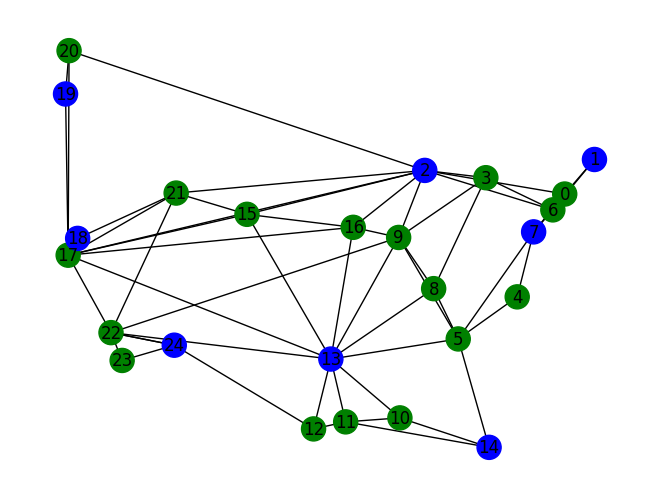

In [16]:
  # Draw the graph with node colors
nx.draw(G, node_color=[node_colors[G.nodes[n]["role"]] for n in G.nodes()], pos=node_positions, labels={node: G.nodes[node]['id'] for node in G.nodes()},with_labels=True)

# Show the plot
plt.show()

In [17]:
setSelectedCon()

In [18]:
seed = 650631030  # seed value for reproducibility
packet_rate = 400    # average rate or expected value
size = amount_of_switch  # number of switch

# Creating a random number generator with a fixed seed
rng = np.random.default_rng(seed)

# Generating values from a Poisson distribution using the seeded generator
packet_size = rng.poisson(lam=packet_rate, size=size)

print("Generated Poisson samples with fixed seed:", packet_size)

Generated Poisson samples with fixed seed: [396 375 413 384 427 446 387 366 385 389 436 406 388 385 472 410 372]


In [19]:
# Define the packet handling capacity for controllers (1500 packets/second)
capacity = 1500

# Find all controller nodes
controllers = [n for n, d in G.nodes(data=True) if d['role'] == "controller"]

# Dictionary to keep track of controller loads
controller_loads = {c: 0 for c in controllers}

hop_counts = {}
packet_amount = {}

In [20]:
# Simulate packet generation and handling for a given number of seconds (e.g. 10 seconds)
sim_time = 1
k = 0
for i in range(sim_time):
    # Generate packets for each switch and send to its selected controller
    for node in G.nodes():
        if G.nodes[node]['role'] == 'switch':
            selected_con = G.nodes[node]['selected_con']
            packet_count = packet_size[k]
            k += 1
            packet_amount[node] = packet_count
            path = nx.shortest_path(G, source=node, target=selected_con)
            hop_counts[node] = len(path) - 1
            # if controller_loads[selected_con] + packet_count > capacity:
            #     packet_count = capacity - controller_loads[selected_con]
            controller_loads[selected_con] += packet_count
            # G.nodes[node]['switch_energycost'] = packet_count * hop_counts[node]
            print(f"Switch {node} generated {packet_count} packets and sent to controller {selected_con}")

    # Update controller load every second
    if i % 1 == 0:
        print()
        print("Controller loads after", i+1, "seconds:")
        print(f"Controller capacity: {capacity}",end='\n\n')
        for node in G.nodes():
            if G.nodes[node]['role'] == 'controller':
                print(f"Controller {node} load: {controller_loads[node]} pps")
                if controller_loads[node] > capacity:
                  print(f"Controller {node} is overloaded!")
                #controller_loads[node] = 0
        print()

Switch 0 generated 396 packets and sent to controller 1
Switch 3 generated 375 packets and sent to controller 2
Switch 4 generated 413 packets and sent to controller 7
Switch 5 generated 384 packets and sent to controller 7
Switch 6 generated 427 packets and sent to controller 1
Switch 8 generated 446 packets and sent to controller 13
Switch 9 generated 387 packets and sent to controller 2
Switch 10 generated 366 packets and sent to controller 13
Switch 11 generated 385 packets and sent to controller 13
Switch 12 generated 389 packets and sent to controller 24
Switch 15 generated 436 packets and sent to controller 2
Switch 16 generated 406 packets and sent to controller 2
Switch 17 generated 388 packets and sent to controller 2
Switch 20 generated 385 packets and sent to controller 2
Switch 21 generated 472 packets and sent to controller 2
Switch 22 generated 410 packets and sent to controller 13
Switch 23 generated 372 packets and sent to controller 24

Controller loads after 1 second

In [32]:
packet_amount

{'0': 396,
 '3': 375,
 '4': 413,
 '5': 384,
 '6': 427,
 '8': 446,
 '9': 387,
 '10': 366,
 '11': 385,
 '12': 389,
 '15': 436,
 '16': 406,
 '17': 388,
 '20': 385,
 '21': 472,
 '22': 410,
 '23': 372}

In [41]:
def findSwitchtoMigrateList():
  #List of ovelload controlller and swich that need to do migation list
  switches_to_migrate = {}
  overloaded_controllers = [node for node in G.nodes() if G.nodes[node]['role'] == 'controller' and controller_loads[node] > capacity]
  for node in G.nodes():
    if G.nodes[node]['role'] == 'switch' and G.nodes[node]['selected_con'] in overloaded_controllers:
      overloaded_controller = G.nodes[node]['selected_con']
      if overloaded_controller not in switches_to_migrate:
        switches_to_migrate[overloaded_controller] = []
      switches_to_migrate[overloaded_controller].append([node,packet_amount[node]])
      # switches_to_migrate[node] = packet_amount[node]
  return(switches_to_migrate)


switches_to_migrate = findSwitchtoMigrateList()
switches_to_migrate

{'2': [['3', 375],
  ['9', 387],
  ['15', 436],
  ['16', 406],
  ['17', 388],
  ['20', 385],
  ['21', 472]],
 '13': [['8', 446], ['10', 366], ['11', 385], ['22', 410]]}

In [ ]:
switches_to_migrate = {'3': 375,
 '8': 446,
 '9': 387,
 '10': 366,
 '11': 385,
 '15': 436,
 '16': 406,
 '17': 388,
 '20': 385,
 '21': 472,
 '22': 410}

In [ ]:
printSwitchController()

Controller node 1 controls the following switches:
- Switch node 0
- Switch node 6

Controller node 2 controls the following switches:
- Switch node 3
- Switch node 9
- Switch node 15
- Switch node 16
- Switch node 17
- Switch node 20
- Switch node 21

Controller node 7 controls the following switches:
- Switch node 4
- Switch node 5

Controller node 13 controls the following switches:
- Switch node 8
- Switch node 10
- Switch node 11
- Switch node 22

Controller node 14 controls the following switches:

Controller node 18 controls the following switches:

Controller node 19 controls the following switches:

Controller node 24 controls the following switches:
- Switch node 12
- Switch node 23



### Min-Knapsack

In [ ]:
'''
def min_knapsack(overloaded_controllers, switches_to_migrate, capacity):
    # Calculate the target load for each overloaded controller
    target_loads = {c: controller_loads[c] - (0.9 * capacity) for c in overloaded_controllers}
    
    # Initialize the result dictionary
    switches_to_migrate_set = {}
    
    for controller in overloaded_controllers:
        # Calculate the excess load for the overloaded controller
        excess_load = controller_loads[controller] - target_loads[controller]
        
        # Get the list of switches connected to the overloaded controller
        connected_switches = [(switch, load) for switch, load in switches_to_migrate.items() if G.nodes[switch]['selected_con'] == controller]
        
        # Sort the switches in descending order of their loads
        connected_switches.sort(key=lambda x: x[1], reverse=True)
        
        # Initialize the list of switches to migrate for this controller
        switches_to_migrate_set[controller] = []
        
        # Iterate through the sorted switches and add them to the migration list until the excess load is less than or equal to 0
        for switch, load in connected_switches:
            if excess_load <= 0:
                break
            switches_to_migrate_set[controller].append(switch)
            excess_load -= load
            
    return switches_to_migrate_set
'''

In [ ]:
'''
# Find the switches to migrate for each overloaded controller
overloaded_controllers = [node for node in G.nodes() if G.nodes[node]['role'] == 'controller' and controller_loads[node] > capacity]
switches_to_migrate = findSwitchtoMigrateList()
result = min_knapsack(overloaded_controllers, switches_to_migrate, capacity)

# print("Switches to migrate for each overloaded controller:")
# for controller, switches in result.items():
#     print(f"Controller {controller}: {', '.join(switches)}")
'''

In [77]:
def findCandidateControllerList():
  # Find new candidate controllers for overloaded controller
  switch_to_candidate_controller = []
  for overload_controller, switches in switches_to_migrate.items():
    for switch, load in switches:
      selected_con = overload_controller
      candidate_controllers = [n for n, d in G.nodes(data=True) if d['role'] == "controller" and n != selected_con and controller_loads[n] < capacity]
      if candidate_controllers:
          hop_counts = []
          for con in candidate_controllers:
              path = nx.astar_path(G, source=switch, target=con)
              hop_count = len(path) - 1
              hop_counts.append((con, hop_count))
          sorted_hops = sorted(hop_counts, key=lambda x: (x[1], controller_loads[x[0]]), reverse=False)
          controller_list = []
          for con in sorted_hops:
              controller_list.append([con[0], con[1], capacity - controller_loads[con[0]]])
          switch_to_candidate_controller.append([switch, load] + controller_list)
      else:
          switch_to_candidate_controller.append([switch, load])
  return switch_to_candidate_controller

In [78]:
switch_to_candidate_controller = findCandidateControllerList()
switch_to_candidate_controller
# ['SwitchID', 'Switch load', ['Dest.ControllerID', 'Hop count from switch to controller', 'Controller capacity left']]

[['3',
  375,
  ['7', 2, 703],
  ['1', 2, 677],
  ['14', 3, 1500],
  ['18', 3, 1500],
  ['19', 3, 1500],
  ['24', 3, 739]],
 ['9',
  387,
  ['14', 2, 1500],
  ['24', 2, 739],
  ['7', 2, 703],
  ['18', 3, 1500],
  ['19', 3, 1500],
  ['1', 3, 677]],
 ['15',
  436,
  ['18', 2, 1500],
  ['19', 2, 1500],
  ['14', 3, 1500],
  ['24', 3, 739],
  ['7', 3, 703],
  ['1', 3, 677]],
 ['16',
  406,
  ['18', 2, 1500],
  ['19', 2, 1500],
  ['14', 3, 1500],
  ['24', 3, 739],
  ['7', 3, 703],
  ['1', 3, 677]],
 ['17',
  388,
  ['18', 1, 1500],
  ['19', 1, 1500],
  ['24', 2, 739],
  ['14', 3, 1500],
  ['7', 3, 703],
  ['1', 3, 677]],
 ['20',
  385,
  ['19', 1, 1500],
  ['18', 2, 1500],
  ['24', 3, 739],
  ['7', 3, 703],
  ['1', 3, 677],
  ['14', 4, 1500]],
 ['21',
  472,
  ['18', 1, 1500],
  ['19', 2, 1500],
  ['24', 2, 739],
  ['7', 3, 703],
  ['1', 3, 677],
  ['14', 4, 1500]],
 ['8',
  446,
  ['14', 2, 1500],
  ['7', 2, 703],
  ['18', 3, 1500],
  ['19', 3, 1500],
  ['24', 3, 739],
  ['1', 3, 677]],
 ['

In [49]:
switches_to_migrate = {'3': 375,
 '8': 446,
 '9': 387,
 '10': 366,
 '11': 385,
 '15': 436,
 '16': 406,
 '17': 388,
 '20': 385,
 '21': 472,
 '22': 410}

In [76]:
'''
def findCandidateControllerList():
  # Find new candidate controllers for overloaded controller
  switch_to_candidate_controller = []
  for switch, load in switches_to_migrate.items():
      selected_con = G.nodes[switch]['selected_con']
      candidate_controllers = [n for n, d in G.nodes(data=True) if d['role'] == "controller" and n != selected_con and controller_loads[n] < capacity]
      if candidate_controllers:
          hop_counts = []
          for con in candidate_controllers:
              path = nx.astar_path(G, source=switch, target=con)
              hop_count = len(path) - 1
              hop_counts.append((con, hop_count))
          sorted_hops = sorted(hop_counts, key=lambda x: (x[1], controller_loads[x[0]]), reverse=False)
          controller_list = []
          for con in sorted_hops:
              controller_list.append([con[0], con[1], capacity - controller_loads[con[0]]])
          switch_to_candidate_controller.append([switch, load] + controller_list)
      else:
          switch_to_candidate_controller.append([switch, load])
  return switch_to_candidate_controller
'''

In [ ]:
'''
switch_to_candidate_controller = findCandidateControllerList()
switch_to_candidate_controller
# ['SwitchID', 'Switch load', ['ControllerID', 'Hop count from switch to controller', 'Controller capacity left']]
'''

In [79]:
#Show candidate controller list of switch that connected with overload controller
for i in switch_to_candidate_controller:
  print(f"Switch {i[0]} ({i[1]} pps) can migrate to the following controllers:")
  for con in i[2:]:
    print(f" Controller {con[0]} (Hop count: {con[1]}, Capacity left: {con[2]})")

Switch 3 (375 pps) can migrate to the following controllers:
 Controller 7 (Hop count: 2, Capacity left: 703)
 Controller 1 (Hop count: 2, Capacity left: 677)
 Controller 14 (Hop count: 3, Capacity left: 1500)
 Controller 18 (Hop count: 3, Capacity left: 1500)
 Controller 19 (Hop count: 3, Capacity left: 1500)
 Controller 24 (Hop count: 3, Capacity left: 739)
Switch 9 (387 pps) can migrate to the following controllers:
 Controller 14 (Hop count: 2, Capacity left: 1500)
 Controller 24 (Hop count: 2, Capacity left: 739)
 Controller 7 (Hop count: 2, Capacity left: 703)
 Controller 18 (Hop count: 3, Capacity left: 1500)
 Controller 19 (Hop count: 3, Capacity left: 1500)
 Controller 1 (Hop count: 3, Capacity left: 677)
Switch 15 (436 pps) can migrate to the following controllers:
 Controller 18 (Hop count: 2, Capacity left: 1500)
 Controller 19 (Hop count: 2, Capacity left: 1500)
 Controller 14 (Hop count: 3, Capacity left: 1500)
 Controller 24 (Hop count: 3, Capacity left: 739)
 Controller

In [177]:
def min_knapsack2_mod(switches_to_migrate, switch_to_candidate_controller, capacity):
    # Calculate the target load for each overloaded controller (weight of knapsack)
    target_loads = {overloaded_controller: controller_loads[overloaded_controller] - (0.9 * capacity) for overloaded_controller in switches_to_migrate}
    print(f'target_loads: {target_loads}')

    # Initialize the result dictionary that `min_knapsack2` will return as an output of this function
    delta_E_per_controller = {}

    for overloaded_controllers in switches_to_migrate:
      x1 = []
      switches = switches_to_migrate[overloaded_controllers]
      switches = {switch[0]: switch[1] for switch in switches}

      for switch, load in switches.items():
        # Find the corresponding candidate controllers list for this switch
        controller_candidates = [ candidate for item in switch_to_candidate_controller if item[0] == switch and overloaded_controllers == G.nodes[switch]["selected_con"] for candidate in item[2:] if candidate[2] >= load]
        # Calculate delta_E for each candidate controller
        delta_Es = [[switch, candidate[0], load * (candidate[1] - hop_counts[switch])] for candidate in controller_candidates]
        if delta_Es:
          min_element = min(delta_Es, key=lambda x: x[2])
          result = [min_element]
          x1.append(result)
      x1 = sorted(x1, key=lambda x: min(sublist[2] for sublist in x))
      print(f'from con{overloaded_controllers}: {x1}')

      x2 = []
      total_loads = 0
      for sublist in x1:
        passed_condition = True
        new_total_loads = total_loads
        for switch, con, delta_E in sublist:
          passed_condition = True
          new_total_loads = total_loads
          for switch, con, delta_E in sublist:
            if switch in switches and new_total_loads < target_loads[overloaded_controllers]:
                new_total_loads += switches[switch]
            else:
                passed_condition = False
                break
          
          if passed_condition:
              x2.append(sublist)
              total_loads = new_total_loads
      
      if overloaded_controllers in delta_E_per_controller:
          delta_E_per_controller[overloaded_controllers].append(x2)
      else:
          delta_E_per_controller[overloaded_controllers] = x2

    return delta_E_per_controller

In [178]:
switches_to_migrate = findSwitchtoMigrateList()
result = min_knapsack2_mod(switches_to_migrate, switch_to_candidate_controller, capacity)
for controller, switches in result.items():
  for switch in switches:
    print(f"Controller {controller} : Migrate switch {switch[0][0]} to controller {switch[0][1]} with delta_E {switch[0][2]}")

target_loads: {'2': 1499.0, '13': 257.0}
from con2: [[['17', '18', 0]], [['20', '19', 0]], [['21', '18', 0]], [['3', '7', 375]], [['9', '14', 387]], [['16', '18', 406]], [['15', '18', 436]]]
from con13: [[['10', '14', 0]], [['11', '14', 0]], [['22', '24', 0]], [['8', '14', 446]]]
Controller 2 : Migrate switch 17 to controller 18 with delta_e 0
Controller 2 : Migrate switch 20 to controller 19 with delta_e 0
Controller 2 : Migrate switch 21 to controller 18 with delta_e 0
Controller 2 : Migrate switch 3 to controller 7 with delta_e 375
Controller 13 : Migrate switch 10 to controller 14 with delta_e 0


In [54]:
def min_knapsack2(overloaded_controllers, switches_to_migrate, switch_to_candidate_controller, capacity):
    # Calculate the target load for each overloaded controller (weight of knapsack)
    target_loads = {c: controller_loads[c] - (0.9 * capacity) for c in overloaded_controllers}
    print(f'target_loads: {target_loads}')

    # Initialize the result dictionary that `min_knapsack2` will return as an output of this function
    delta_E_per_controller = {}

    for overloaded_con in overloaded_controllers:
        x1 = []
        for switch, load in switches_to_migrate.items():
            # Calculate delta_E for each switch

            # Find the corresponding candidate controllers list for this switch
            controller_candidates = [
                candidate
                for item in switch_to_candidate_controller
                if item[0] == switch and overloaded_con == G.nodes[switch]["selected_con"]
                for candidate in item[2:]
                if candidate[2] >= load
            ]
            # Calculate delta_E for each candidate controller
            delta_Es = [
                [switch, candidate[0], load * (candidate[1] - hop_counts[switch])]
                for candidate in controller_candidates
            ]
            if delta_Es:
                min_element = min(delta_Es, key=lambda x: x[2])
                result = [min_element]
                # min_value = min(e[2] for e in delta_Es) 
                # result = [e for e in delta_Es if e[2] == min_value]
                x1.append(result)
        x1 = sorted(x1, key=lambda x: min(sublist[2] for sublist in x))
        print(f'from con{overloaded_con}: {x1}')
        
        x2 = []
        total_loads = 0
        for sublist in x1:
            passed_condition = True
            new_total_loads = total_loads
            for switch, con, delta_E in sublist:
                if switch in switches_to_migrate and new_total_loads < target_loads[overloaded_con]:
                    new_total_loads += switches_to_migrate[switch]
                else:
                    passed_condition = False
                    break

            if passed_condition:
                x2.append(sublist)
                total_loads = new_total_loads
        
        if overloaded_con in delta_E_per_controller:
            delta_E_per_controller[overloaded_con].append(x2)
        else:
            delta_E_per_controller[overloaded_con] = x2
    return delta_E_per_controller


In [55]:
# Find the switches to migrate for each overloaded controller
overloaded_controllers = [node for node in G.nodes() if G.nodes[node]['role'] == 'controller' and controller_loads[node] > capacity]
switches_to_migrate = findSwitchtoMigrateList()
result = min_knapsack2(overloaded_controllers, switches_to_migrate, switch_to_candidate_controller, capacity)
for controller, switches in result.items():
  for switch in switches:
    print(f"Controller {controller} : Migrate switch {switch[0][0]} to controller {switch[0][1]} with delta_e {switch[0][2]}")

target_loads: {'2': 1499.0, '13': 257.0}
from con2: []
from con13: []


### Aproach delta_E
---
Working by
1.   Calculate energy cost from each switch to its present controller by load*hopcount (E_before) 
2.   Calculate energy cost from each switch to each candidate controller list
3.   Sort energy cost from (2.)
4.   The least hop count with higest capacity left is chossen from each switch to new candidate controller then calculate energy cost from switch to each candidate controller (E_after)
5.   Get the list of pairs of switch and candidate controller with (delta_E = E_after-E_before)
6.   The list of pair of switch and candidate controller with the lowest delta_E will be migrate as following pair.
7.   Do migration until capacity of overload controller become underbound

In [ ]:
def findSwitchtoMigrate(G, overloaded_controllers, switches_to_migrate, capacity):
    controller_loads_temp = copy.deepcopy(controller_loads)
    migrate_list = []
    # Sort the overloaded controllers by load (descending order)
    sorted_overloaded_controllers = sorted(overloaded_controllers, key=lambda x: controller_loads_temp[x], reverse=True)
    print(f'Controller list (DESC): {sorted_overloaded_controllers}')

    for overloaded_con in sorted_overloaded_controllers:
        # Get the switches connected to the overloaded controller
        connected_switches = [node for node in G.nodes() if G.nodes[node]['role'] == 'switch' and G.nodes[node]['selected_con'] == overloaded_con]

        for switch in switches_to_migrate:
            E_after = {}
            load = switches_to_migrate[switch]
            selected_con = G.nodes[switch]['selected_con']
            selected_con_path = nx.shortest_path(G, source=switch, target=selected_con)
            hop_count_to_oc = len(selected_con_path) - 1
            E_before = load * hop_count_to_oc
            candidate_controllers = [n for n, d in G.nodes(data=True) if d['role'] == "controller" and n != selected_con and controller_loads_temp[n] < capacity]
            if candidate_controllers:
                hop_counts = []
                sorted_hops1 = []
                for con in candidate_controllers:
                    path = nx.shortest_path(G, source=switch, target=con)
                    hop_count = len(path) - 1
                    hop_counts.append((con, hop_count))

                sorted_hops = sorted(hop_counts, key=lambda x: (x[1], controller_loads_temp[x[0]]), reverse=False)

                # Find the first candidate controller that can handle the load
                lowest_value = sorted_hops[0][1]  # get the first tuple's second value as the initial lowest value
                B = []  # create an empty list for the new tuples

                # iterate through each tuple in sorted_hops and check if its second value is equal to the lowest value
                for tup in sorted_hops:
                    if tup[1] == lowest_value:
                        B.append((tup[0], lowest_value))  # add the tuple to the new list with the lowest value
                sorted_hops = B

                for con in sorted_hops:
                    if controller_loads_temp[selected_con] >= capacity:
                      if controller_loads_temp[con[0]] + load <= capacity:
                        E_after[con[0]] = load * con[1]
                        delta_E = E_after[con[0]] - E_before
                        migrate_list.append((switch,[con[0],delta_E]))

            else:
                print(f"No candidate controllers found for switch {switch}")
    return migrate_list

In [ ]:
G_temp = copy.deepcopy(G)
overloaded_controllers_temp = copy.deepcopy(overloaded_controllers)
switches_to_migrate_temp = copy.deepcopy(switches_to_migrate)
migrate_list = findSwitchtoMigrate(G_temp, overloaded_controllers_temp, switches_to_migrate_temp, capacity)
# migrate_list = findSwitchtoMigrate(G, overloaded_controllers, switches_to_migrate, capacity)
migrate_list

Controller list (DESC): ['2', '13']


[('3', ['7', 385]),
 ('3', ['1', 385]),
 ('8', ['14', 404]),
 ('8', ['7', 404]),
 ('9', ['14', 418]),
 ('9', ['24', 418]),
 ('9', ['7', 418]),
 ('10', ['14', 0]),
 ('11', ['14', 0]),
 ('15', ['18', 416]),
 ('15', ['19', 416]),
 ('16', ['18', 409]),
 ('16', ['19', 409]),
 ('17', ['18', 0]),
 ('17', ['19', 0]),
 ('20', ['19', 0]),
 ('21', ['18', 0]),
 ('22', ['24', 0]),
 ('3', ['7', 385]),
 ('3', ['1', 385]),
 ('8', ['14', 404]),
 ('8', ['7', 404]),
 ('9', ['14', 418]),
 ('9', ['24', 418]),
 ('9', ['7', 418]),
 ('10', ['14', 0]),
 ('11', ['14', 0]),
 ('15', ['18', 416]),
 ('15', ['19', 416]),
 ('16', ['18', 409]),
 ('16', ['19', 409]),
 ('17', ['18', 0]),
 ('17', ['19', 0]),
 ('20', ['19', 0]),
 ('21', ['18', 0]),
 ('22', ['24', 0])]

In [ ]:
migrate_list
B_dict = {}
for item in migrate_list:
    key, value = item
    if key not in B_dict or value[1] < B_dict[key][1][1]:
        B_dict[key] = item

switch_to_new_controller = list(B_dict.values())
# print(migrate_list)
print(switch_to_new_controller)
# SwitchID, ControllerID, Switch's load

[('3', ['7', 354]), ('8', ['14', 399]), ('9', ['14', 385]), ('10', ['14', 0]), ('11', ['14', 0]), ('15', ['18', 407]), ('16', ['18', 414]), ('17', ['18', 0]), ('20', ['19', 0]), ('21', ['18', 0]), ('22', ['24', 0])]


In [ ]:
printCandidateController()

Switch 3 (354 pps) can migrate to the following controllers:
 - Controller 7 (Hop count: 2, Capacity left: 714)
 - Controller 1 (Hop count: 2, Capacity left: 683)
 - Controller 14 (Hop count: 3, Capacity left: 1500)
 - Controller 18 (Hop count: 3, Capacity left: 1500)
 - Controller 19 (Hop count: 3, Capacity left: 1500)
 - Controller 24 (Hop count: 3, Capacity left: 674)
Switch 8 (399 pps) can migrate to the following controllers:
 - Controller 14 (Hop count: 2, Capacity left: 1500)
 - Controller 7 (Hop count: 2, Capacity left: 714)
 - Controller 18 (Hop count: 3, Capacity left: 1500)
 - Controller 19 (Hop count: 3, Capacity left: 1500)
 - Controller 1 (Hop count: 3, Capacity left: 683)
 - Controller 24 (Hop count: 3, Capacity left: 674)
Switch 9 (385 pps) can migrate to the following controllers:
 - Controller 14 (Hop count: 2, Capacity left: 1500)
 - Controller 7 (Hop count: 2, Capacity left: 714)
 - Controller 24 (Hop count: 2, Capacity left: 674)
 - Controller 18 (Hop count: 3, Cap

In [ ]:
# def migrate_switches_min(G, overloaded_controllers, switches_to_migrate, capacity):
#     controller_loads_temp = copy.deepcopy(controller_loads)
#     # Sort the overloaded controllers by load (descending order)
#     sorted_overloaded_controllers = sorted(overloaded_controllers, key=lambda x: controller_loads_temp[x], reverse=True)
#     print(f'Controller list (DESC): {sorted_overloaded_controllers}')

#     for overloaded_con in sorted_overloaded_controllers:
#         print(f"Migrating switches from overloaded controller {overloaded_con}")
#         # Get the switches connected to the overloaded controller
#         connected_switches = [node for node in G.nodes() if G.nodes[node]['role'] == 'switch' and G.nodes[node]['selected_con'] == overloaded_con]
#         # Sort the connected switches by load (descending order)
#         sorted_connected_switches = sorted(connected_switches, key=lambda x: switches_to_migrate[x], reverse=False)
#         print(sorted_connected_switches)

#         for switch in sorted_connected_switches:
#             load = switches_to_migrate[switch]
#             selected_con = G.nodes[switch]['selected_con']
#             candidate_controllers = [n for n, d in G.nodes(data=True) if d['role'] == "controller" and n != selected_con and controller_loads_temp[n] < capacity]
#             if candidate_controllers:
#                 hop_counts = []
#                 for con in candidate_controllers:
#                     path = nx.shortest_path(G, source=switch, target=con)
#                     hop_count = len(path) - 1
#                     hop_counts.append((con, hop_count))

#                 sorted_hops = sorted(hop_counts, key=lambda x: (x[1], controller_loads_temp[x[0]]), reverse=False)

#                 # Find the first candidate controller that can handle the load
#                 for con in sorted_hops:
#                     if controller_loads_temp[selected_con] >= capacity:
#                       if controller_loads_temp[con[0]] + load <= capacity:
#                         # Perform the switch migration
#                         print(f"Migrating switch {switch} from controller {selected_con} to {con[0]}")
#                         controller_loads_temp[selected_con] -= load
#                         controller_loads_temp[con[0]] += load
#                         G.nodes[switch]['selected_con'] = con[0]
#                         print(f"Controller load {selected_con} is {controller_loads_temp[selected_con]}")
#                         break
#             else:
#                 print(f"No candidate controllers found for switch {switch}")

In [ ]:
def migrate_switches_Edelta(G, overloaded_controllers, switches_to_migrate, switch_to_new_controller, capacity):
  controller_loads_temp = controller_loads
  sorted_overloaded_controllers = sorted(overloaded_controllers, key=lambda x: controller_loads_temp[x], reverse=True)
  
  for overloaded_con in sorted_overloaded_controllers:
    for switch in switch_to_new_controller:
      load = switches_to_migrate[switch[0]]
      selected_con = G.nodes[switch[0]]['selected_con']
      if G.nodes[switch[0]]['selected_con'] == overloaded_con:
        if controller_loads_temp[selected_con] >= capacity:
          print(f"Migrating switch {switch[0]} from controller {selected_con} to {switch[1][0]}")
          controller_loads_temp[selected_con] -= load
          controller_loads_temp[switch[1][0]] += load
          G.nodes[switch[0]]['selected_con'] = switch[1][0]
          print(f"Controller load {selected_con} is {controller_loads_temp[selected_con]}")

### Evaluate energy cost

In [ ]:
def energycostCalculate(G):
  hop_counts = {}
  energycost_oneswitch = {}
  total_energyconsume = 0
  switches_to_migrate = {}

  for node in G.nodes():
    if G.nodes[node]['role'] == 'switch':
      selected_con = G.nodes[node]['selected_con']
      path = nx.shortest_path(G, source=node, target=selected_con)
      hop_counts[node] = len(path) - 1
      energycost_oneswitch[node] = packet_amount[node]  * hop_counts[node]

  #Calculate energy cost from all switches by its load and hop counts to its controller
  for switch, ec_oneswitch in energycost_oneswitch.items():
      total_energyconsume += ec_oneswitch
  
  return total_energyconsume

In [ ]:
#Energy cost before migrate
print(f'Energy consume: {energycostCalculate(G)}')

Energy consume: 6843


Do migration

In [ ]:
migrate_switches_Edelta(G, overloaded_controllers, switches_to_migrate, switch_to_new_controller, capacity)
energycostCalculate(G)

Migrating switch 3 from controller 2 to 7
Controller load 2 is 2404
Migrating switch 9 from controller 2 to 14
Controller load 2 is 2026
Migrating switch 15 from controller 2 to 18
Controller load 2 is 1641
Migrating switch 16 from controller 2 to 18
Controller load 2 is 1222
Migrating switch 8 from controller 13 to 14
Controller load 13 is 1201
Energy consume from all switches: 8838


In [ ]:
for node in G.nodes:
  if G.nodes[node]['role'] == 'switch':
    print(f'Switch {G.nodes[node]["id"]} controlled with Controller {G.nodes[node]["selected_con"]}')
print()
for node in G.nodes:
  if G.nodes[node]['role'] == 'controller':
                print(f"Controller {node} load: {controller_loads[node]} pps")


Switch 0 controlled with Controller 1
Switch 3 controlled with Controller 7
Switch 4 controlled with Controller 7
Switch 5 controlled with Controller 7
Switch 6 controlled with Controller 1
Switch 8 controlled with Controller 14
Switch 9 controlled with Controller 14
Switch 10 controlled with Controller 13
Switch 11 controlled with Controller 13
Switch 12 controlled with Controller 24
Switch 15 controlled with Controller 18
Switch 16 controlled with Controller 18
Switch 17 controlled with Controller 2
Switch 20 controlled with Controller 2
Switch 21 controlled with Controller 2
Switch 22 controlled with Controller 13
Switch 23 controlled with Controller 24

Controller 1 load: 822 pps
Controller 2 load: 1222 pps
Controller 7 load: 1182 pps
Controller 13 load: 1201 pps
Controller 14 load: 788 pps
Controller 18 load: 804 pps
Controller 19 load: 0 pps
Controller 24 load: 797 pps


In [ ]:
G_temp = copy.deepcopy(G)
overloaded_controllers_temp = copy.deepcopy(overloaded_controllers)
switches_to_migrate_temp = copy.deepcopy(switches_to_migrate)
switch_to_new_controller_temp = copy.deepcopy(switch_to_new_controller)
migrate_switches_Edelta(G_temp, overloaded_controllers_temp, switches_to_migrate_temp, switch_to_new_controller_temp, capacity)
#Energy cost after migrate
energycostCalculate(G_temp)

Migrating switch 3 from controller 2 to 1
Controller load 2 is 2397
Migrating switch 9 from controller 2 to 14
Controller load 2 is 1996
Migrating switch 15 from controller 2 to 18
Controller load 2 is 1593
Migrating switch 16 from controller 2 to 18
Controller load 2 is 1192
Migrating switch 8 from controller 13 to 14
Controller load 13 is 1177
Energy consume from all switches: 8817
